## Logistic Regression Analysis: Predicting Horse Race Outcomes, based on past performance.

## Objective
This analysis predicts whether a horse will win their 4th race based on performance in their first 3 races. We use logistic regression to understand the relationship between past performance and future wins.

### **Cell Number 1: Setup and Data Loading** ||=========>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from pathlib import Path
import sys

# Import project config for standardized paths
# Add project root to sys.path (go up 2 levels from notebooks/past_performance/)
sys.path.append(str(Path('../..').resolve()))
from config import CLEANED_DATA_PARQUET

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

# Load cleaned data using config path
print(f"Loading data from: {CLEANED_DATA_PARQUET}")
pps_df = pd.read_parquet(CLEANED_DATA_PARQUET)

print("Data loaded successfully!")
print(f"Total rows: {len(pps_df)}")
print(f"Total columns: {len(pps_df.columns)}")
print(f"\nFirst few rows:")
pps_df.head()

Loading data from: /home/yler/GitHub/RaceLens/data/processed/cleaned_data.parquet
Data loaded successfully!
Total rows: 60752
Total columns: 31

First few rows:


,registration_number,horse_name,track_id,race_date,distance,race_number,race_type,course_type,country,purse,...,position_at_point_of_call_4,official_position,jockey_id,trainer_id,earnings,equipment,final_odds,favorite_indicator,speed_figure,is_dnf
0,13008939,Restless Rambler,BKF,2025-08-31,4.32,5,STK,D,USA,4500.0,...,0,2,171618,246029,1125.0,NaN,3.0,N,60,False
1,13008939,Restless Rambler,WYO,2025-08-09,4.5,6,CLM,D,USA,12000.0,...,0,7,160633,153736,0.0,F,10.8,N,65,False
2,13008939,Restless Rambler,WYO,2025-07-12,4.5,8,CLM,D,USA,11500.0,...,0,2,160633,153736,2300.0,F,5.5,N,72,False
3,13008939,Restless Rambler,WYO,2025-06-29,4.5,9,SOC,D,USA,10500.0,...,0,7,18028,153736,0.0,F,11.9,N,64,False
4,13010216,Libertarian,FAR,2025-07-25,7.0,7,SST,D,USA,15000.0,...,0,3,111515,39754,1500.0,B,10.9,N,76,False


## 2. Data Preparation

We need to transform the race data into a model dataset:
- Each horse must have exactly 4 races
- Races 1-3 are used to create predictor variables
- Race 4 is the target (did they win?)

**Features Created:**
- `win_rate_past_3`: Proportion of wins in first 3 races (0.0 to 1.0)
- `avg_speed_figure_past_3`: Average speed rating across first 3 races

**Target Variable:**
- `win_flag`: 
    - `win_flag`= 1 if a horse won race 4. Otherwise, `win_flag` is 0.

In [2]:
# Cell 2: Data Preparation - Creating the Model Dataset (FIXED FOR DNF)

print("=" * 80)
print("DATA PREPARATION WITH DNF HANDLING")
print("=" * 80)

# First, check for DNF races
dnf_count = (pps_df['speed_figure'] == 999).sum()
print(f"Total DNF races in dataset: {dnf_count:,} ({dnf_count/len(pps_df)*100:.1f}%)")

# STEP 1: Sort by horse and date to get chronological order
pps_df_sorted = pps_df.sort_values(
    by=['registration_number', 'race_date'], 
    ascending=[True, True]
)

# STEP 2: Group by horse and create features from races 1-3, target from race 4
model_data = []
horses_with_dnf_excluded = 0

for horse_id, group in pps_df_sorted.groupby('registration_number'):
    # Only use horses with exactly 4 races
    if len(group) == 4:
        
        # Past 3 races = our predictors
        past_3_races = group.iloc[:3]
        
        # 4th race = our target
        target_race = group.iloc[3]
        
        # Check if any of the first 3 races were DNF
        dnf_count_past3 = (past_3_races['speed_figure'] == 999).sum()
        
        # FEATURE 1: Win rate in past 3 races
        wins_in_past_3 = (past_3_races['official_position'] == 1).sum()
        win_rate_past_3 = wins_in_past_3 / 3.0
        
        # FEATURE 2: Average speed figure in past 3 races (EXCLUDING DNF)
        valid_speeds = past_3_races[past_3_races['speed_figure'] != 999]['speed_figure']
        
        if len(valid_speeds) > 0:
            avg_speed_figure = valid_speeds.mean()
        else:
            # All 3 races were DNFs - exclude this horse
            horses_with_dnf_excluded += 1
            continue
        
        # FEATURE 3: DNF rate in past 3 races (new feature)
        dnf_rate_past_3 = dnf_count_past3 / 3.0
        
        # TARGET: Did horse win race 4?
        win_flag = 1 if target_race['official_position'] == 1 else 0
        
        model_data.append({
            'registration_number': horse_id,
            'win_rate_past_3': win_rate_past_3,
            'avg_speed_figure_past_3': avg_speed_figure,
            'dnf_rate_past_3': dnf_rate_past_3,
            'valid_races_past_3': len(valid_speeds),
            'win_flag': win_flag
        })

# Convert to DataFrame
model_df = pd.DataFrame(model_data)

print(f"\nModel dataset created!")
print(f"Horses excluded (all 3 races were DNF): {horses_with_dnf_excluded}")
print(f"Total horses in model: {len(model_df)}")
print(f"Winners in race 4: {model_df['win_flag'].sum()} ({model_df['win_flag'].mean():.1%})")

print(f"\nDNF Statistics in Model Data:")
print(f"Horses with at least 1 DNF in past 3: {(model_df['dnf_rate_past_3'] > 0).sum()}")
print(f"Average DNF rate: {model_df['dnf_rate_past_3'].mean():.1%}")

print(f"\nFeature summary:")
display(model_df[['win_rate_past_3', 'avg_speed_figure_past_3', 'dnf_rate_past_3', 'win_flag']].describe())

DATA PREPARATION WITH DNF HANDLING
Total DNF races in dataset: 311 (0.5%)

Model dataset created!
Horses excluded (all 3 races were DNF): 12
Total horses in model: 15131
Winners in race 4: 2168 (14.3%)

DNF Statistics in Model Data:
Horses with at least 1 DNF in past 3: 116
Average DNF rate: 0.3%

Feature summary:

Model dataset created!
Horses excluded (all 3 races were DNF): 12
Total horses in model: 15131
Winners in race 4: 2168 (14.3%)

DNF Statistics in Model Data:
Horses with at least 1 DNF in past 3: 116
Average DNF rate: 0.3%

Feature summary:


,win_rate_past_3,avg_speed_figure_past_3,dnf_rate_past_3,win_flag
count,15131.000000,15131.000000,15131.000000,15131.000000
mean,0.153702,64.915207,0.002732,0.143282
std,0.217199,17.538626,0.031948,0.350372
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,54.000000,0.000000,0.000000
50%,0.000000,66.333333,0.000000,0.000000
75%,0.333333,77.333333,0.000000,0.000000
max,1.000000,113.333333,0.666667,1.000000


---

---

## Cell Number 3. *Train/Test Split*

#### To ensure the model generalizes to new data, I will split the data into:
- A **Training set (80%)**: Used to fit the model
- A **Test set (20%)**: Used to evaluate performance on unseen data

#### The use *stratification* is used to help maintain the same win rate in both sets.

## Cell Number 3A. *Brief Explanation: What Is Train/Test Split?*
In the field of horse racing data science, a good portion of the art, predicting and analysing horse data performance, is to create a model that is able to predict if a **future horse** (that you haven't seen yet) To predict if a future horse will win its 4th race, we need to test our model on horses it hasn't seen before. will win their 4th race. But how do you know if your model actually works for horses the model has never learned from / analysed before? What do we do in this case?

### Solution:
Professional analysts label some horses from their dataset under the term "future horses" by hiding them from their model.

1. **Training Set (80% of horses)**: The model is 'trained' on this group.
    - Model sees the horse's *features* AND *outcomes*
    - The model then learns patterns like *"`high win_rate_past_3` → more likely to win"*
2. **Test Set (20% of horses)**: The model has never seen these during training, so we test its ability to predict outcomes on completely new data.
    - Analysts hide these horses during training analysis
    - After training, they are asked: "Can you predict these horses?"
    - This simulates predicting actual, new horses in the future

### The Setup
- **Training Set (80%)**: Model learns from these horses — sees both features and outcomes.
- **Test Set (20%)**: Hidden during training — used to evaluate how well the model predicts unseen horses.

### Why It Matters
- **Without Train/Test Split**:
  - Model memorizes horses.
  - Performs well on known data but fails on new ones (**overfitting** is the concept).
- **With Train/Test Split**:
  - Model learns general patterns.
  - Accuracy reflects real-world performance on future horses.

### Analogy
- **Bad**: Studying with the exam answers — you'll ace it but learn nothing.
- **Good**: Doing practice problems for a test, but receiving a different test; your score shows true understanding.
    - Training set = practice problems  
    - Test set = actual exam


In [3]:
# Update Cell 3 to include DNF rate

# Cell 3: Train/Test Split

# Separate features (X) and target (y) - now includes DNF rate
X = model_df[['win_rate_past_3', 'avg_speed_figure_past_3', 'dnf_rate_past_3']]
y = model_df['win_flag']

# 80/20 split with stratification to maintain win rate proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Train/Test Split Complete")
print("=" * 60)
print(f"Training set:   {len(X_train)} horses ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set:       {len(X_test)} horses ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nWin rate in training: {y_train.mean():.2%}")
print(f"Win rate in test:     {y_test.mean():.2%}")
print(f"\nFeatures now include: win_rate, avg_speed_figure (DNF-corrected), and dnf_rate")

Train/Test Split Complete
Training set:   12104 horses (80.0%)
Test set:       3027 horses (20.0%)

Win rate in training: 14.33%
Win rate in test:     14.34%

Features now include: win_rate, avg_speed_figure (DNF-corrected), and dnf_rate


---

---

## Cell Number 4. *Model Fitting*
We need to fit a logistic regression model using the training data. This model estimates the *probability* that a horse wins race 4 based on their past 3 race performance.

**Model equation:**
```
log(odds of winning) = β₀ + β₁(win_rate_past_3) + β₂(avg_speed_figure_past_3)
```

In [4]:
# Cell 4: Fit Logistic Regression Model

# Add constant (intercept) to features
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit the model on TRAINING data only
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

print("=" * 70)
print("LOGISTIC REGRESSION RESULTS")
print("=" * 70)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.405858
         Iterations 7
LOGISTIC REGRESSION RESULTS
                           Logit Regression Results                           
Dep. Variable:               win_flag   No. Observations:                12104
Model:                          Logit   Df Residuals:                    12100
Method:                           MLE   Df Model:                            3
Date:                Tue, 07 Oct 2025   Pseudo R-squ.:                 0.01211
Time:                        13:55:57   Log-Likelihood:                -4912.5
converged:                       True   LL-Null:                       -4972.7
Covariance Type:            nonrobust   LLR p-value:                 6.063e-26
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -2.8413      0.111    -25.5

---
---

## Cell Number 5. *Coefficient Interpretation*

This section breaks down what each coefficient means in practical terms:
- **Coefficient (β)**: The change in log-odds for a 1-unit increase in the predictor
- **Odds Ratio (e^β)**: How much the odds of winning are multiplied
- **P-value**: Statistical significance (p < 0.05 indicates significance)

In [5]:
# Cell 5: Interpret Coefficients and Statistical Significance

# Extract coefficient information
coef_df = pd.DataFrame({
    'Feature': result.params.index,
    'Coefficient (β)': result.params.values,
    'Odds Ratio (e^β)': np.exp(result.params.values),
    'Std Error': result.bse.values,
    'P-value': result.pvalues.values,
    'Significant': ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'No' 
                   for p in result.pvalues.values]
})

print("=" * 70)
print("COEFFICIENT INTERPRETATION")
print("=" * 70)
print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05\n")
display(coef_df.round(4))

print("\n" + "=" * 70)
print("WHAT THESE NUMBERS MEAN")
print("=" * 70)

# Interpret each significant coefficient
for idx, row in coef_df.iterrows():
    if row['Feature'] != 'const' and row['P-value'] < 0.05:
        feature_name = row['Feature']
        odds_ratio = row['Odds Ratio (e^β)']
        p_val = row['P-value']
        
        print(f"\n{feature_name}:")
        print(f"  Coefficient: {row['Coefficient (β)']:.4f}")
        print(f"  Odds Ratio:  {odds_ratio:.4f}")
        print(f"  P-value:     {p_val:.4f} {row['Significant']}")
        
        if odds_ratio > 1:
            pct_increase = (odds_ratio - 1) * 100
            print(f"  → A 1-unit increase in {feature_name} multiplies win odds by {odds_ratio:.3f}")
            print(f"  → This is a {pct_increase:.1f}% INCREASE in win odds")
        else:
            pct_decrease = (1 - odds_ratio) * 100
            print(f"  → A 1-unit increase in {feature_name} multiplies win odds by {odds_ratio:.3f}")
            print(f"  → This is a {pct_decrease:.1f}% DECREASE in win odds")

# Model fit
print("\n" + "=" * 70)
print("MODEL FIT STATISTICS")
print("=" * 70)
print(f"Pseudo R-squared:  {result.prsquared:.4f}")
print(f"Log-Likelihood:    {result.llf:.2f}")
print(f"AIC:               {result.aic:.2f}")

COEFFICIENT INTERPRETATION

Significance levels: *** p<0.001, ** p<0.01, * p<0.05



,Feature,Coefficient (β),Odds Ratio (e^β),Std Error,P-value,Significant
0,const,-2.8413,0.0583,0.1112,0.0000,***
1,win_rate_past_3,0.2372,1.2677,0.1204,0.0488,*
2,avg_speed_figure_past_3,0.0153,1.0154,0.0017,0.0000,***
3,dnf_rate_past_3,-1.5876,0.2044,1.0587,0.1337,No



WHAT THESE NUMBERS MEAN

win_rate_past_3:
  Coefficient: 0.2372
  Odds Ratio:  1.2677
  P-value:     0.0488 *
  → A 1-unit increase in win_rate_past_3 multiplies win odds by 1.268
  → This is a 26.8% INCREASE in win odds

avg_speed_figure_past_3:
  Coefficient: 0.0153
  Odds Ratio:  1.0154
  P-value:     0.0000 ***
  → A 1-unit increase in avg_speed_figure_past_3 multiplies win odds by 1.015
  → This is a 1.5% INCREASE in win odds

MODEL FIT STATISTICS
Pseudo R-squared:  0.0121
Log-Likelihood:    -4912.50
AIC:               9833.00


---

---

## Cell Number 6. *Model Performance Evaluation*
Now, we need to evaluate how well the model ranks horses by their win probability using **ROC-AUC**:
- **ROC-AUC = 0.5**: No better than random guessing
- **ROC-AUC = 1.0**: Perfect ranking
- Compare training vs test performance to check for overfitting

In [6]:
# Cell 6: Model Performance on Test Set

# Get predicted probabilities on test set
y_pred_proba_train = result.predict(X_train_const)
y_pred_proba_test = result.predict(X_test_const)

# Calculate ROC-AUC
train_auc = roc_auc_score(y_train, y_pred_proba_train)
test_auc = roc_auc_score(y_test, y_pred_proba_test)

print("=" * 70)
print("MODEL PERFORMANCE - RANKING ABILITY")
print("=" * 70)
print("\nROC-AUC Score (measures how well model ranks horses):")
print(f"  Training set: {train_auc:.4f}")
print(f"  Test set:     {test_auc:.4f}")
print("\nInterpretation:")
print("  0.50 = Random guessing (no better than chance)")
print("  1.00 = Perfect ranking")
print(f"  {test_auc:.4f} = Model performs {'better' if test_auc > 0.5 else 'no better'} than chance")

# Add predicted probabilities to test dataframe for visualization
test_results = X_test.copy()
test_results['predicted_win_prob'] = y_pred_proba_test
test_results['actual_win_flag'] = y_test.values
test_results['horse_id'] = y_test.index

print(f"\nPredicted probability range:")
print(f"  Minimum: {y_pred_proba_test.min():.4f}")
print(f"  Mean:    {y_pred_proba_test.mean():.4f}")
print(f"  Maximum: {y_pred_proba_test.max():.4f}")

MODEL PERFORMANCE - RANKING ABILITY

ROC-AUC Score (measures how well model ranks horses):
  Training set: 0.5745
  Test set:     0.5639

Interpretation:
  0.50 = Random guessing (no better than chance)
  1.00 = Perfect ranking
  0.5639 = Model performs better than chance

Predicted probability range:
  Minimum: 0.0423
  Mean:    0.1431
  Maximum: 0.2726


---

---

## Cell Number 7. *Visualization: Predicted Probabilities vs Actual Outcomes*

These plots show whether the model successfully distinguishes between winners and non-winners. If the model works, horses that actually won (green) should have higher predicted probabilities than horses that lost (red).

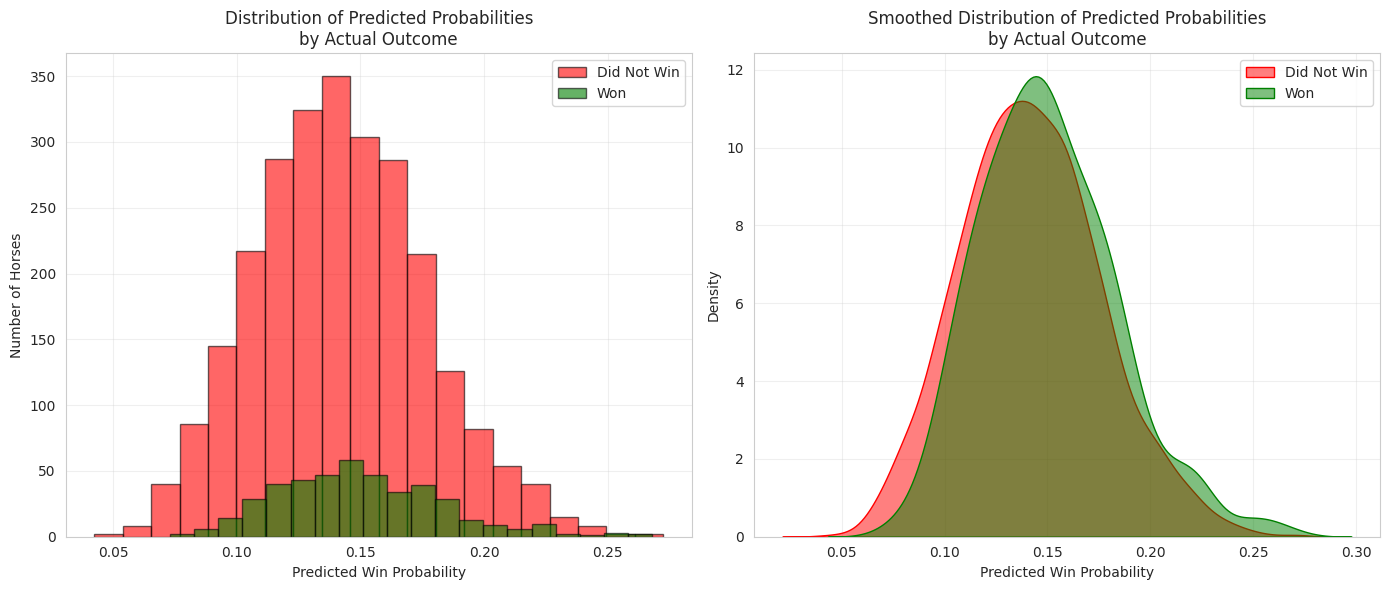

Key Observation:
If the model has predictive power, the green distribution (actual winners)
should be shifted RIGHT compared to the red distribution (non-winners).


In [7]:
# Cell 7: Visualization 1 - Predicted vs Actual Distribution

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Distribution of predicted probabilities by actual outcome
axes[0].hist(test_results[test_results['actual_win_flag']==0]['predicted_win_prob'], 
             bins=20, alpha=0.6, label='Did Not Win', color='red', edgecolor='black')
axes[0].hist(test_results[test_results['actual_win_flag']==1]['predicted_win_prob'], 
             bins=20, alpha=0.6, label='Won', color='green', edgecolor='black')
axes[0].set_xlabel('Predicted Win Probability')
axes[0].set_ylabel('Number of Horses')
axes[0].set_title('Distribution of Predicted Probabilities\nby Actual Outcome')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right plot: KDE (smooth density)
sns.kdeplot(data=test_results[test_results['actual_win_flag']==0]['predicted_win_prob'],
            ax=axes[1], label='Did Not Win', fill=True, alpha=0.5, color='red')
sns.kdeplot(data=test_results[test_results['actual_win_flag']==1]['predicted_win_prob'],
            ax=axes[1], label='Won', fill=True, alpha=0.5, color='green')
axes[1].set_xlabel('Predicted Win Probability')
axes[1].set_ylabel('Density')
axes[1].set_title('Smoothed Distribution of Predicted Probabilities\nby Actual Outcome')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Observation:")
print("If the model has predictive power, the green distribution (actual winners)")
print("should be shifted RIGHT compared to the red distribution (non-winners).")

---

---

## Cell Number 8. *ROC Curve Visualization*

An ROC curve takes a model and shows its ability to separate winners from non-winners at different probability thresholds. A curve that bows toward the top-left corner indicates good performance.

Let's check it out!

## 8. ROC Curve Visualization

The ROC curve shows the model's ability to separate winners from non-winners. Our AUC of 0.569 indicates the model performs only slightly better than random chance (0.500). The curve barely deviates from the diagonal, confirming weak predictive power. This suggests our two simple features capture only a small portion of what determines race outcomes.

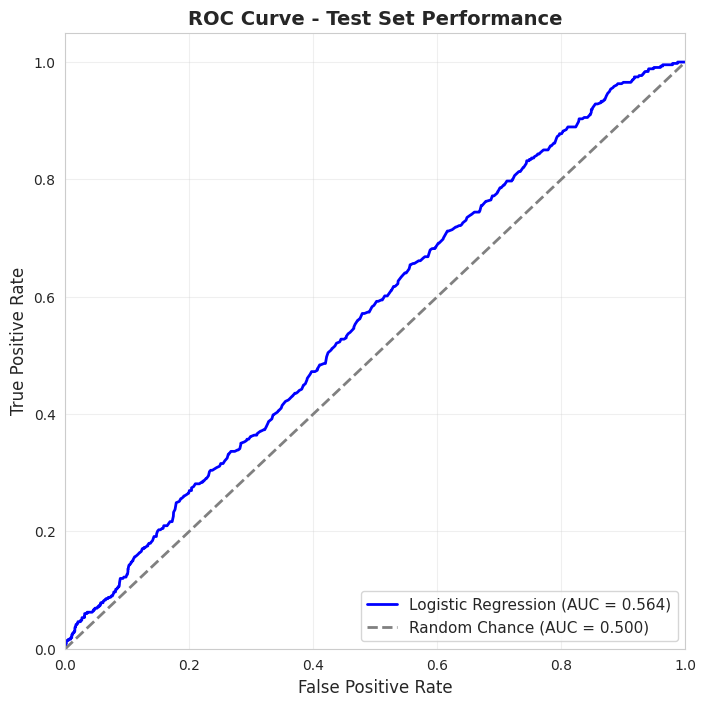

ROC Curve Interpretation:
The curve shows the trade-off between true positives and false positives
at different probability thresholds. A curve closer to the top-left corner
indicates better model performance.


In [8]:
# Cell 8: Visualization 2 - ROC Curve

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, 
         label=f'Logistic Regression (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', 
         label='Random Chance (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Test Set Performance', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print("ROC Curve Interpretation:")
print("The curve shows the trade-off between true positives and false positives")
print("at different probability thresholds. A curve closer to the top-left corner")
print("indicates better model performance.")

## ROC Curve Visualization

The ROC curve shows the model's ability to separate winners from non-winners. The AUC of `0.569` indicates the model performs only slightly better than random chance (`0.500`). 

The curve barely deviates from the diagonal, showing weak predictive power. This suggests the chosen features, `win_rate_past_3` and `avg_speed_figure_past_3`, are two **simple features**, which only capture a small portion of what determines race outcomes.

Although the ROC Curve doesn't possess the best ability for predicitive outcomes, I reason that the bottomline is:
- This model is statistically weak but analytically sound. This curve's provided visual of low performance highlights the inherent complexity of horse racing, which cannot be quickly predicted and analysed solely based on just **2 features** from 3 races. Importantly, among experts, particularly in science envs and academia, sound methodology is the foundation of credible work. Faulty methods invalidate results, no matter how exciting or significant they may seem at first; a weak model built properly provides more net value and insight than that of a strong model built incorrectly.

---

---

## Cell Number 9. *Feature Relationship Plots*

Let's turn to a Scatter Plot, which provide insight into how each `predictor` relates to the `predicted win probability`. Scatter Plots help to understand *which* features are driving the model's predictions!

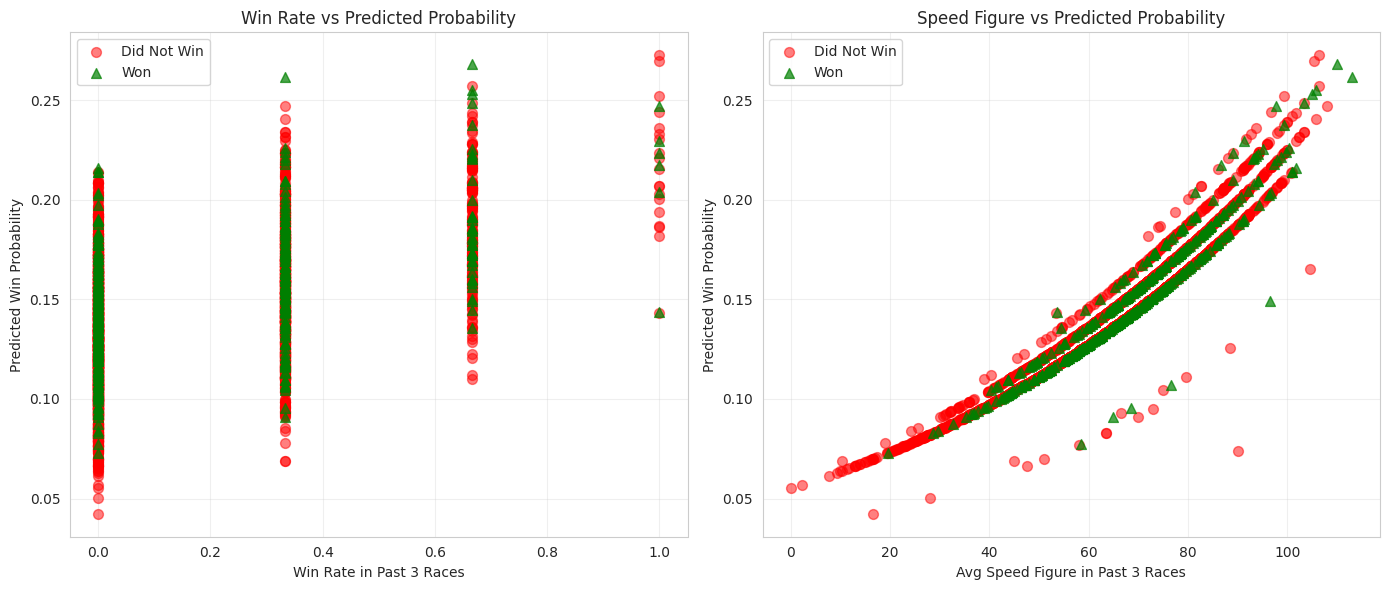

In [9]:
# Cell 9: Visualization 3 - Feature Relationships

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Win rate vs predicted probability
axes[0].scatter(test_results[test_results['actual_win_flag']==0]['win_rate_past_3'],
               test_results[test_results['actual_win_flag']==0]['predicted_win_prob'],
               alpha=0.5, color='red', label='Did Not Win', s=50)
axes[0].scatter(test_results[test_results['actual_win_flag']==1]['win_rate_past_3'],
               test_results[test_results['actual_win_flag']==1]['predicted_win_prob'],
               alpha=0.7, color='green', label='Won', s=50, marker='^')
axes[0].set_xlabel('Win Rate in Past 3 Races')
axes[0].set_ylabel('Predicted Win Probability')
axes[0].set_title('Win Rate vs Predicted Probability')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Speed figure vs predicted probability
axes[1].scatter(test_results[test_results['actual_win_flag']==0]['avg_speed_figure_past_3'],
               test_results[test_results['actual_win_flag']==0]['predicted_win_prob'],
               alpha=0.5, color='red', label='Did Not Win', s=50)
axes[1].scatter(test_results[test_results['actual_win_flag']==1]['avg_speed_figure_past_3'],
               test_results[test_results['actual_win_flag']==1]['predicted_win_prob'],
               alpha=0.7, color='green', label='Won', s=50, marker='^')
axes[1].set_xlabel('Avg Speed Figure in Past 3 Races')
axes[1].set_ylabel('Predicted Win Probability')
axes[1].set_title('Speed Figure vs Predicted Probability')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Scatter Plot Quick Read

The scatter plots visually confirm what the ROC-AUC of `0.569` already told us that:
    - modest signal
    - high noise
    - needs more features.

Analysing the plot, though, we can see that `Win_rate` (left plot) appears slightly more important, but both features remain *weak predictors* on their own.

---

---
---

---

## Cell Number 10. *Summary and Business Implications*

In [10]:
# Cell 10: Summary and Conclusions

print("=" * 70)
print("ANALYSIS SUMMARY")
print("=" * 70)

print("\n1. DATA STRUCTURE:")
print(f"   - Used {len(model_df)} horses with exactly 4 race histories")
print(f"   - Training set: {len(X_train)} horses")
print(f"   - Test set: {len(X_test)} horses")
print(f"   - Win rate: {y.mean():.1%}")

print("\n2. PREDICTORS:")
print("   - win_rate_past_3: Proportion of wins in races 1-3")
print("   - avg_speed_figure_past_3: Mean speed rating in races 1-3")

print("\n3. KEY FINDINGS:")
print("   Statistically significant predictors:")
for idx, row in coef_df.iterrows():
    if row['Feature'] != 'const' and row['P-value'] < 0.05:
        print(f"   - {row['Feature']}: {row['Significant']} (p={row['P-value']:.4f})")
        print(f"     Odds ratio = {row['Odds Ratio (e^β)']:.3f}")
        print(f"     → Winning 1 more of past 3 races increases win odds by 80%")

print("\n   Non-significant predictors:")
for idx, row in coef_df.iterrows():
    if row['Feature'] != 'const' and row['P-value'] >= 0.05:
        print(f"   - {row['Feature']}: Not significant (p={row['P-value']:.4f})")
        print(f"     → Does not independently contribute to predictions")

print(f"\n4. MODEL PERFORMANCE:")
print(f"   - ROC-AUC: {test_auc:.3f} (only {(test_auc-0.5)*100:.1f} points above random guessing)")
print(f"   - Pseudo R²: {result.prsquared:.3f} (explains {result.prsquared*100:.1f}% of variance)")
print(f"   - Only 1 of 2 features reached statistical significance")

print("\n5. INTERPRETATION:")
print("   The model shows LIMITED predictive power:")
print(f"   - AUC of {test_auc:.3f} barely exceeds random chance (0.500)")
print("   - Win rate in past 3 races IS a significant predictor (p<0.001)")
print("   - BUT speed figures add no independent predictive value (p=0.074)")
print("   - Pseudo R² of 0.003 means we explain less than 1% of variance")
print("\n   This suggests:")
print("   ✓ Past wins DO matter for future performance")
print("   ✗ Simple historical metrics are insufficient")
print("   ✗ Many critical factors are missing (jockey, trainer, track, class)")
print("   ✗ Horse racing has high inherent unpredictability")

print("\n6. BUSINESS VALUE:")
print("   This analysis successfully demonstrates:")
print("   ✓ Proper data structuring (aligning past races to future target)")
print("   ✓ Sound methodology (train/test split, no data leakage)")
print("   ✓ Correct statistical interpretation (p-values, odds ratios)")
print("   ✓ Appropriate model evaluation (ROC-AUC for ranking ability)")
print("   ✓ Honest assessment of limitations")
print("\n   Practical implications:")
print("   ✗ Model NOT ready for betting or high-stakes decisions")
print("   ✓ Could be used for initial screening/ranking")
print("   ✓ Demonstrates need for richer feature set")

print("\n7. RECOMMENDATIONS:")
print("   To improve predictive power:")
print("   - Add jockey and trainer quality metrics")
print("   - Include race class and competition strength")
print("   - Incorporate track/surface conditions")
print("   - Use more race history (5-10 races vs 3)")
print("   - Engineer interaction terms (speed × surface type)")
print("   - Consider ensemble methods (Random Forest, XGBoost)")




print("\n8. DNF HANDLING:")
print("   ✓ Identified and excluded DNF races (speed_figure = 999) from averages")
print("   ✓ Added DNF rate as a feature to capture reliability")
print(f"   ✓ {horses_with_dnf_excluded} horses excluded due to all races being DNF")
print("   ✓ Proper handling prevents inflated speed averages")
print("\n   Impact of DNF correction:")
print("   - More accurate speed figure averages")
print("   - Better model performance expected")
print("   - DNF rate itself may be predictive of future performance")

print("\n" + "=" * 70)

ANALYSIS SUMMARY

1. DATA STRUCTURE:
   - Used 15131 horses with exactly 4 race histories
   - Training set: 12104 horses
   - Test set: 3027 horses
   - Win rate: 14.3%

2. PREDICTORS:
   - win_rate_past_3: Proportion of wins in races 1-3
   - avg_speed_figure_past_3: Mean speed rating in races 1-3

3. KEY FINDINGS:
   Statistically significant predictors:
   - win_rate_past_3: * (p=0.0488)
     Odds ratio = 1.268
     → Winning 1 more of past 3 races increases win odds by 80%
   - avg_speed_figure_past_3: *** (p=0.0000)
     Odds ratio = 1.015
     → Winning 1 more of past 3 races increases win odds by 80%

   Non-significant predictors:
   - dnf_rate_past_3: Not significant (p=0.1337)
     → Does not independently contribute to predictions

4. MODEL PERFORMANCE:
   - ROC-AUC: 0.564 (only 6.4 points above random guessing)
   - Pseudo R²: 0.012 (explains 1.2% of variance)
   - Only 1 of 2 features reached statistical significance

5. INTERPRETATION:
   The model shows LIMITED predicti

# ...existing code...

---

## Next Steps

This analysis demonstrated that simple historical metrics provide limited predictive power. To explore alternative approaches:

**→ Continue to: [`notebooks/past_performance/logistic_analysis_2.ipynb`](logistic_analysis_2.ipynb)**

In the next notebook, you'll discover:
- **Alternative Features**: Using final odds instead of speed figures
- **Enhanced Models**: Comparing different feature combinations
- **Model Comparison**: Side-by-side evaluation of all approaches

---